<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Weather_GPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
import matplotlib.pyplot as plt
import pandas as pd
import pylab as py


In [2]:
data = pd.read_excel('/content/drive/My Drive/50136-Mohe.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

data["MA"] = data["ET0"].shift(1, freq='d').rolling('3d', min_periods=1).mean()

data = data.dropna()

data.head()

,DOY,T,VPD,gamma,Delta,U,Rn,ET0,MA
TIMESTAMP,,,,,,,,,
1990-01-02,2,-33.2,0.006802,0.067381,4.935265,0.0,3.149681,1.267761,1.236897
1990-01-03,3,-33.5,0.005730,0.067381,4.941713,0.0,3.172246,1.276866,1.252329
1990-01-04,4,-31.8,0.002196,0.067381,4.905367,0.0,1.194855,0.480895,1.260508
1990-01-05,5,-22.9,0.026560,0.067381,4.722477,1.8,3.223596,1.288056,1.008507
1990-01-06,6,-27.9,0.011176,0.067381,4.823721,0.3,3.154401,1.267654,1.015272


In [3]:
data[data["ET0"].isna()].head()

,DOY,T,VPD,gamma,Delta,U,Rn,ET0,MA
TIMESTAMP,,,,,,,,,


Text(0, 0.5, 'ET0')

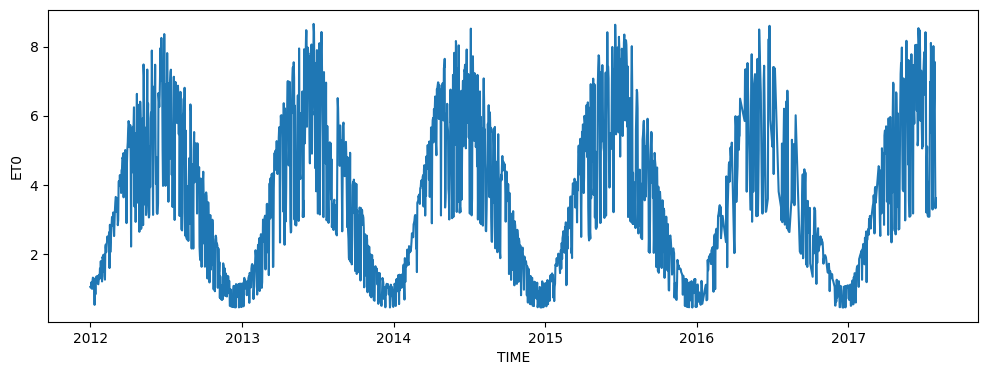

In [4]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

subData = data.loc["2012":"2017-7-31"]
N = len(subData)
x = subData.index
y = subData["ET0"]
z = subData["MA"]

ax.plot(x, y)
ax.set_xlabel("TIME")
ax.set_ylabel("ET0")

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, ExpSineSquared, Matern, RationalQuadratic
from sklearn import linear_model

# nDelay = int(nDelay)
nDelay = 3

XS = np.zeros((N-nDelay, nDelay+1))
ys = np.zeros(N-nDelay)
zs = np.zeros(N-nDelay)
for i in range(0, N-nDelay):
  XS[i,:nDelay] = y[i:i+nDelay]
  XS[i,nDelay] = z[i+nDelay]
  ys[i] = y[i+nDelay]
  zs[i] = z[i+nDelay]

dy = 0.05*ys

################################################################
kernel =  RBF() * C() + WhiteKernel() + C() * ExpSineSquared() # + WhiteKernel()  + C() * ExpSineSquared()  #*  C() * Matern() +RationalQuadratic()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=dy**2)
gp.fit(XS, ys)
################################################################



GaussianProcessRegressor(alpha=array([0.00284551, 0.00242785, 0.00368676, ..., 0.05543467, 0.02754555,
       0.03257547]),
                         copy_X_train=True,
                         kernel=RBF(length_scale=1) * 1**2 + WhiteKernel(noise_level=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=10, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

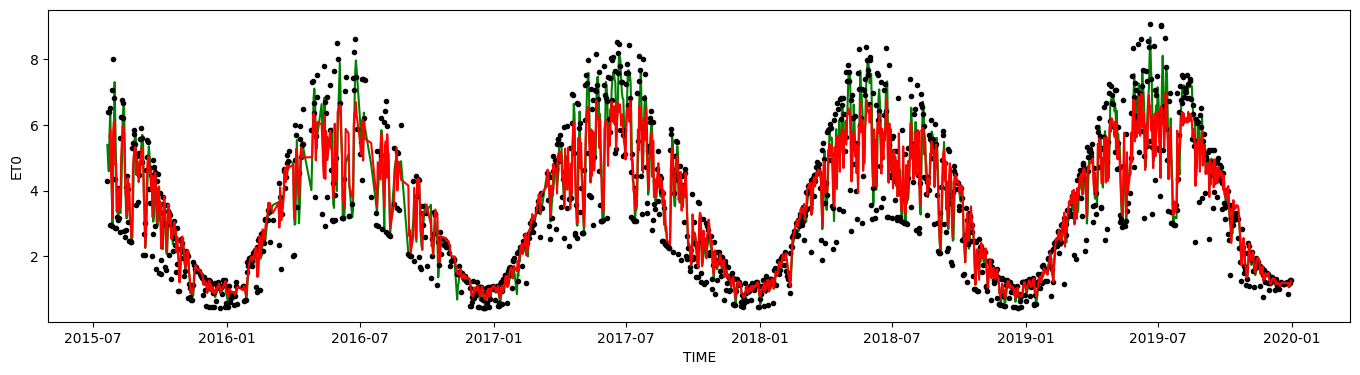

In [8]:
fig = py.figure(figsize=(14, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


subData = data.loc["2015-07-21":]
N = len(subData)
x = subData.index
y = subData["ET0"].values
z = subData["MA"]

ax.plot(x, z, 'g-')

XS = np.zeros((N-nDelay, nDelay+1))
ys = np.zeros(N-nDelay)
zs = np.zeros(N-nDelay)
for i in range(0, N-nDelay):
  XS[i,:nDelay] = y[i:i+nDelay]
  XS[i,nDelay] = z[i+nDelay]
  ys[i] = y[i+nDelay]
  zs[i] = z[i+nDelay]

ax.plot(x, y, 'k.')
ax.set_xlabel("TIME")
ax.set_ylabel("ET0")

ax.plot(subData.iloc[nDelay:N].index, gp.predict(XS), 'r-')




In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_predict = gp.predict(XS)
RMSE = mean_squared_error(ys, y_predict, squared=False)
R2 = r2_score(ys, y_predict)
print(RMSE, R2)


RMSE = mean_squared_error(ys, zs, squared=False)
R2 = r2_score(ys, zs)
print(RMSE, R2)

1.116932797707822 0.7237829405492935
1.21423412766399 0.6735615701622213
